<a href="https://colab.research.google.com/github/TsaiMandy9112/Artificial-Intelligence/blob/main/AI_Chapter8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AutoEncoder**

**Denoising Dirty Documents**

https://www.kaggle.com/competitions/denoising-dirty-documents/data

In [ ]:
# load data
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [ ]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# adapt this if using `channels_first` image data format
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
# adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [ ]:
# adding noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)  # numpy.random.normal 函數裡的三個參數分别代表生成的高斯分布的均值、標準差以及輸出的 size
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# 把 array 限制在一定範圍内
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
# Build Denoising AE model
def train_model():
  # adapt this if using `channels_first` image data format
  input_img = Input(shape=(28, 28, 1))

  # Encoder 使用卷積層，激活函數用 relu，輸入的維度就是上面定義的 input_img
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  # 我們為編碼器設置了一個名稱，以便能夠訪問它
  encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

  # at this point the representation is (4, 4, 8) i.e. 128-dimensional: 4*4*8=128

  # Decoder 的過程與 Encoder 正好相反，需要跟 Encoder 的神經網絡層做相對應，相對應的激活函數也是一樣，但這邊在解碼中最後一層使用的激活函數是 sigmoid
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(16, (3, 3), activation='relu')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  # 用 Model 來搭建模型，輸入為圖片，輸出是解碼的結果
  autoencoder = Model(input_img, decoded)

  # 編譯模型，optimizer 使用 adam，loss 使用 binary_crossentropy
  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

  # 訓練 Denoising AE ，輸入是加入雜訊的圖片，輸出是原始圖片
  autoencoder.fit(x_train_noisy, x_train,
           epochs=20,
           batch_size=128,
           shuffle=True,
           validation_data=(x_test_noisy, x_test),
           callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

  # 保存模型的動作
  autoencoder.save('autoencoder.h5')

train_model()

Epoch 1/20
469/469 [==============================] - 108s 223ms/step - loss: 0.6835 - accuracy: 0.7592 - val_loss: 0.6811 - val_accuracy: 0.7822
Epoch 2/20
469/469 [==============================] - 99s 211ms/step - loss: 0.6777 - accuracy: 0.7929 - val_loss: 0.6736 - val_accuracy: 0.7973
Epoch 3/20
469/469 [==============================] - 99s 211ms/step - loss: 0.6669 - accuracy: 0.8014 - val_loss: 0.6583 - val_accuracy: 0.8021
Epoch 4/20
469/469 [==============================] - 103s 220ms/step - loss: 0.6412 - accuracy: 0.8058 - val_loss: 0.6168 - val_accuracy: 0.8061
Epoch 5/20
469/469 [==============================] - 98s 209ms/step - loss: 0.5654 - accuracy: 0.8085 - val_loss: 0.5097 - val_accuracy: 0.8072
Epoch 6/20
469/469 [==============================] - 98s 210ms/step - loss: 0.4848 - accuracy: 0.8088 - val_loss: 0.4778 - val_accuracy: 0.8072
Epoch 7/20
469/469 [==============================] - 96s 205ms/step - loss: 0.4688 - accuracy: 0.8088 - val_loss: 0.4671 - val_

In [ ]:
# model evaluation
import numpy as np
from keras.models import Model
from keras.datasets import mnist
import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
# 紀錄執行時間
import time

print('Loading mnist dataset')
t0 = time.time()
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# 加入 noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
t1 = time.time()
print('mnist dataset loaded in: ', t1-t0)

print('Loading model :')
t0 = time.time()

# Load 先前已訓練好的 Denoising AE 模型
autoencoder = load_model('autoencoder.h5')
t1 = time.time()
# 紀錄模型加載時間
print('Model loaded in: ', t1-t0)

Loading mnist dataset
mnist dataset loaded in:  5.5110924243927
Loading model :
Model loaded in:  0.1952807903289795


313/313 [==============================] - 9s 27ms/step


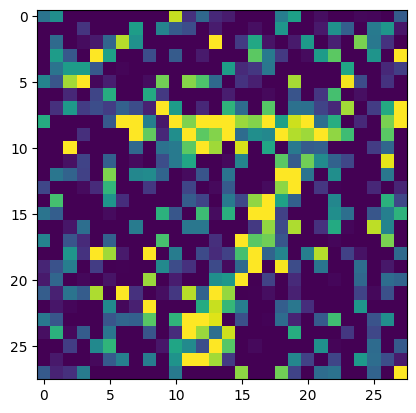

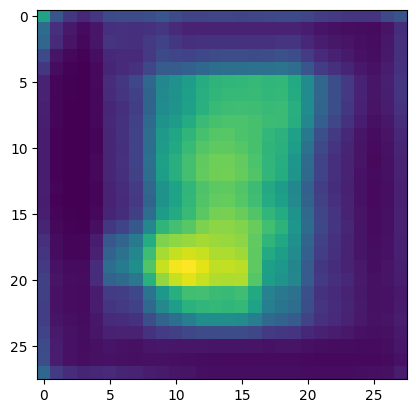

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img

def plot_denoised_images():
  denoised_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2], 1))
  test_img = x_test_noisy[0]
  plt.imshow(test_img)                                    # 在圖表中繪製圖片
  plt.show()

  output = denoised_images[0]
  plt.imshow(output)                                    # 在圖表中繪製圖片
  plt.show()

plot_denoised_images()

In [ ]:
# 目前無法在 Colab 顯示
# Visualization results
def plot_denoised_images():
  denoised_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2], 1))
  test_img = x_test_noisy[0]
  resized_test_img = cv2.resize(test_img, (280, 280))
  cv2.imshow('input', resized_test_img)
  cv2.waitKey(0)
  output = denoised_images[0]
  resized_output = cv2.resize(output, (280, 280))
  cv2.imshow('output', resized_output)
  cv2.waitKey(0)

plot_denoised_images()

313/313 [==============================] - 9s 30ms/step


DisabledFunctionError: ignored

# **VAE 實作**

In [ ]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

# 若出現 _SymbolicException: Inputs to eager execution...
tf.compat.v1.disable_eager_execution()

In [ ]:
# defining the key parameters
batch_size = 100
original_dim = 28*28
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [ ]:
def sampling(args: tuple):
  # we grab the variables from the tuple
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                stddev=epsilon_std)
  return z_mean + K.exp(z_log_var / 2) * epsilon

In [ ]:
# input to our encoder
x = Input(shape=(original_dim,), name="input")
# intermediate layer
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                            

In [ ]:
# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,
       z_log_var=z_log_var, z_mean=z_mean,
       original_dim=original_dim):
  xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
  kl_loss = - 0.5 * K.sum(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  vae_loss = K.mean(xent_loss + kl_loss)
  return vae_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 170us/sample - loss: 190.5165
Epoch 2/50
60000/60000 [==============================] - 10s 161us/sample - loss: 169.8299
Epoch 3/50
60000/60000 [==============================] - 11s 183us/sample - loss: 166.4508
Epoch 4/50
60000/60000 [==============================] - 8s 141us/sample - loss: 164.3427
Epoch 5/50
60000/60000 [==============================] - 10s 161us/sample - loss: 162.8731
Epoch 6/50
60000/60000 [==============================] - 10s 162us/sample - loss: 161.6504
Epoch 7/50
60000/60000 [==============================] - 9s 156us/sample - loss: 160.5351
Epoch 8/50
60000/60000 [==============================] - 10s 162us/sample - loss: 159.4844
Epoch 9/50
60000/60000 [==============================] - 10s 175us/sample - loss: 158.5497
Epoch 10/50
60000/60000 [==============================] - 10s 163us/sample - loss: 157.7510
Epoch 11/50
60000/60000 [==============================] -

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


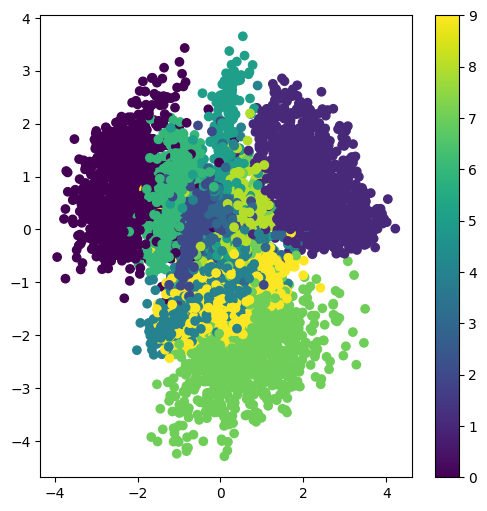

In [ ]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

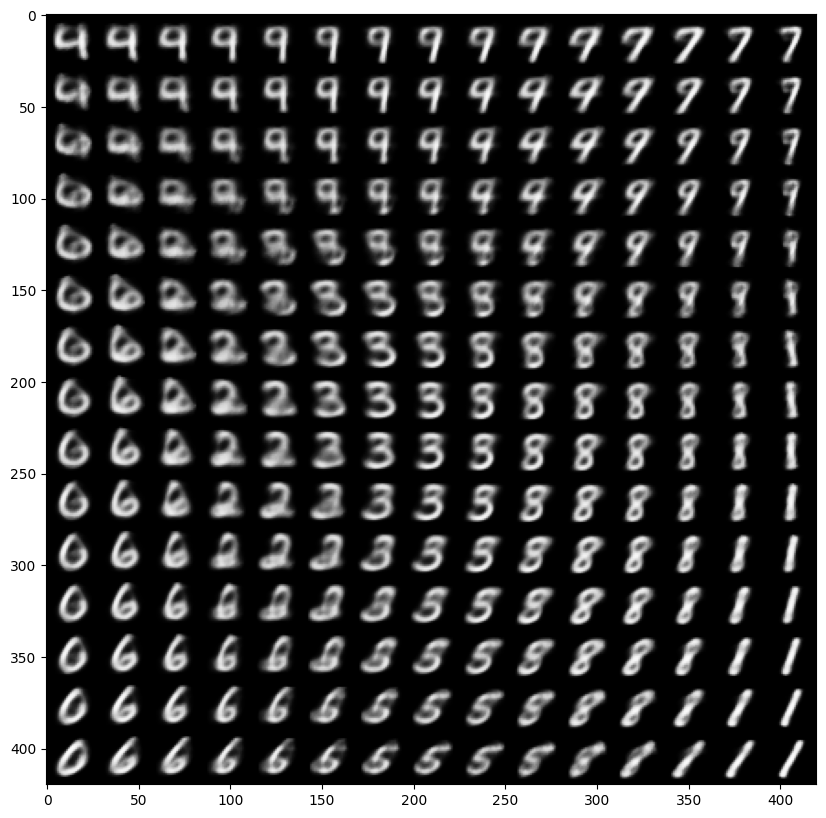

In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size,
        j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

# 實例：生成手寫數字

In [ ]:
# import pachage
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers import LeakyReLU
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

In [ ]:
# Generator
def build_generator(img_shape, z_dim):

  model = Sequential()

  # Fully connected layer
  model.add(Dense(128, input_dim=z_dim))

  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Output layer with tanh activation
  model.add(Dense(28 * 28 * 1, activation='tanh'))

  # Reshape the Generator output to image dimensions
  model.add(Reshape(img_shape))

  return model

In [ ]:
# Discriminator
def build_discriminator(img_shape):

  model = Sequential()

  # Flatten the input image
  model.add(Flatten(input_shape=img_shape))

  # Fully connected layer
  model.add(Dense(128))

  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Output layer with sigmoid activation
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
# Build GAN Model
def build_gan(generator, discriminator):

  model = Sequential()

  # Combined Generator -> Discriminator model
  model.add(generator)
  model.add(discriminator)

  return model

In [ ]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
           optimizer=Adam(),
           metrics=['accuracy'])

# Build the Generator
generator = build_generator(img_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

  # Sample random noise
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

  # Generate images from random noise
  gen_imgs = generator.predict(z)

  # Rescale image pixel values to [0, 1]
  gen_imgs = 0.5 * gen_imgs + 0.5

  # Set image grid
  fig, axs = plt.subplots(image_grid_rows,
                image_grid_columns,
                figsize=(4, 4),
                sharey=True,
                sharex=True)

  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      # Output a grid of images
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

In [ ]:
# Training
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

  # Load the MNIST dataset
  (X_train, _), (_, _) = mnist.load_data()

  # Rescale [0, 255] grayscale pixel values to [-1, 1]
  X_train = X_train / 127.5 - 1.0
  X_train = np.expand_dims(X_train, axis=3)

  # Labels for real images: all ones
  real = np.ones((batch_size, 1))

  # Labels for fake images: all zeros
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):

    # -------------------------
    #  Train the Discriminator
    # -------------------------

    # Get a random batch of real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Generate a batch of fake images
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # Train Discriminator
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train the Generator
    # ---------------------

    # Generate a batch of fake images
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # Train Generator
    g_loss = gan.train_on_batch(z, real)

    if (iteration + 1) % sample_interval == 0:

      # Save losses and accuracies so they can be plotted after training
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      # Output training progress
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
         (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

      # Output a sample of generated image
      sample_images(generator)

In [ ]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━

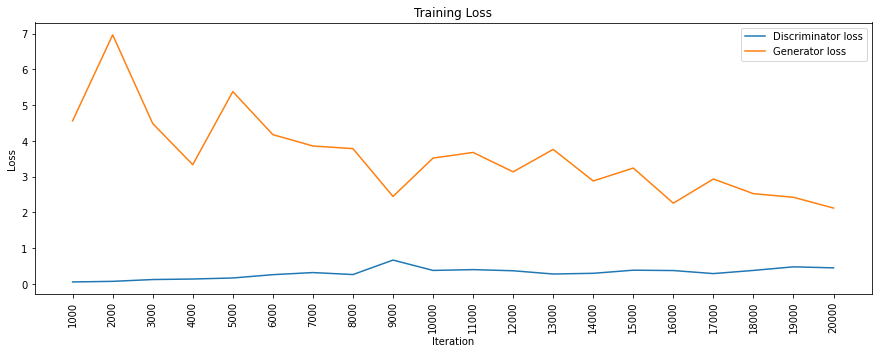

In [ ]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

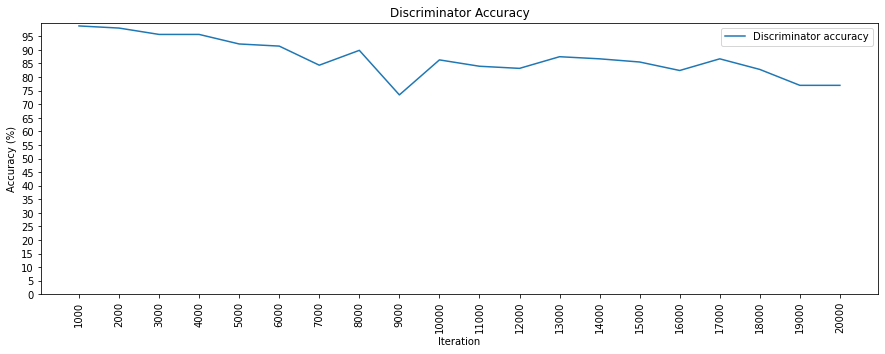

In [ ]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

# DCGAN (深度卷積 GAN)

In [ ]:
# import package
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

In [ ]:
# Generator
def build_generator(z_dim):

  model = Sequential()

  # Reshape input into 7x7x256 tensor via a fully connected layer
  # z_dim = 100
  model.add(Dense(256 * 7 * 7, input_dim=z_dim))
  model.add(Reshape((7, 7, 256)))

  # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

  # Batch normalization
  model.add(BatchNormalization())

  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

  # Batch normalization
  model.add(BatchNormalization())

  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

  # Output layer with tanh activation
  model.add(Activation('tanh'))

  return model

In [ ]:
# Discriminator
def build_discriminator(img_shape):

  model = Sequential()

  # Convolutional layer, from 28x28x1 into 14x14x32 tensor
  model.add(Conv2D(32,
       kernel_size=3,
       strides=2,
       input_shape=img_shape,
       padding='same'))

  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Convolutional layer, from 14x14x32 into 7x7x64 tensor
  model.add(Conv2D(64,
       kernel_size=3,
       strides=2,
       input_shape=img_shape,
       padding='same'))

  # Batch normalization
  model.add(BatchNormalization())

  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
  model.add(Conv2D(128,
       kernel_size=3,
       strides=2,
       input_shape=img_shape,
       padding='same'))

  # Batch normalization
  model.add(BatchNormalization())

  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Output layer with sigmoid activation
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
def build_gan(generator, discriminator):

  model = Sequential()

  # Combined Generator -> Discriminator model
  model.add(generator)
  model.add(discriminator)

  return model

In [ ]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
           optimizer=Adam(),
           metrics=['accuracy'])

# Build the Generator
generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

  # Load the MNIST dataset
  (X_train, _), (_, _) = mnist.load_data()

  # Rescale [0, 255] grayscale pixel values to [-1, 1]
  X_train = X_train / 127.5 - 1.0
  X_train = np.expand_dims(X_train, axis=3)

  # Labels for real images: all ones
  real = np.ones((batch_size, 1))

  # Labels for fake images: all zeros
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):

    # -------------------------
    #  Train the Discriminator
    # -------------------------

    # Get a random batch of real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Generate a batch of fake images
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # Train Discriminator
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train the Generator
    # ---------------------

    # Generate a batch of fake images
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # Train Generator
    g_loss = gan.train_on_batch(z, real)

    if (iteration + 1) % sample_interval == 0:

      # Save losses and accuracies so they can be plotted after training
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      # Output training progress
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

      # Output a sample of generated image
      sample_images(generator)

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

  # Sample random noise
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

  # Generate images from random noise
  gen_imgs = generator.predict(z)

  # Rescale image pixel values to [0, 1]
  gen_imgs = 0.5 * gen_imgs + 0.5

  # Set image grid
  fig, axs = plt.subplots(image_grid_rows,
               image_grid_columns,
               figsize=(4, 4),
               sharey=True,
               sharex=True)

  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      # Output a grid of images
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

11501568/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.000581]
2000 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.000286]
3000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000209]
4000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000248]
5000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000198]
6000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000295]
7000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.003380]
8000 [D loss: 0.000000, acc.: 100.00%] [G loss: 2.061468]
9000 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.628014]
10000 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.462595]
11000 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.378847]
12000 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.099211]
13000 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.240611]
14000 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.083480]
15000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.988038]
16000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.762070]


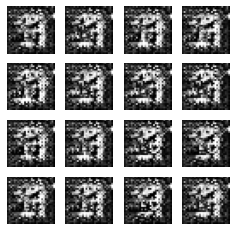

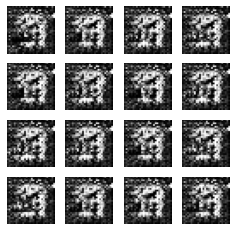

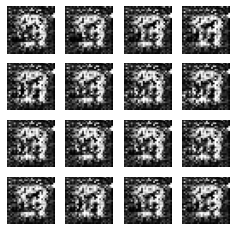

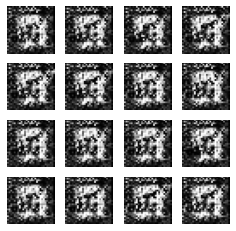

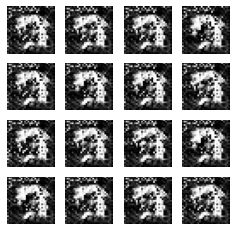

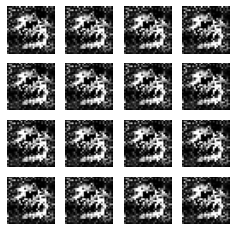

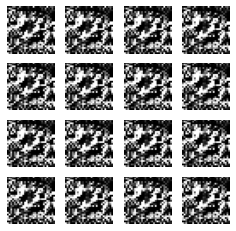

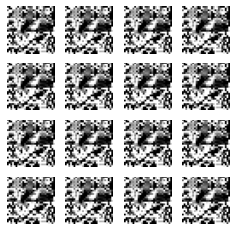

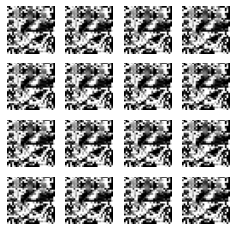

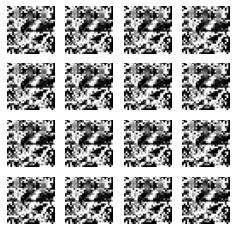

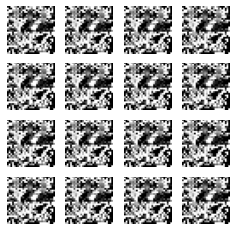

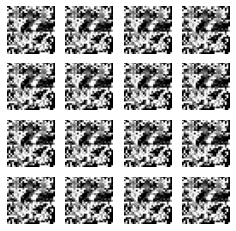

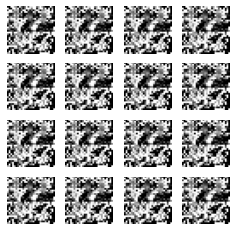

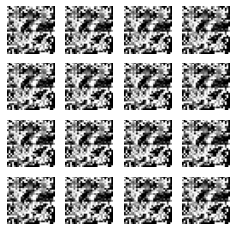

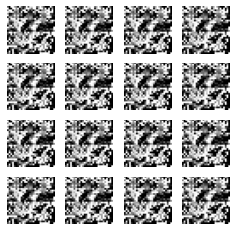

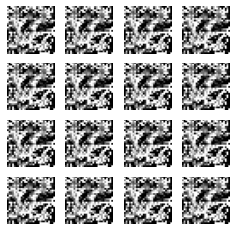

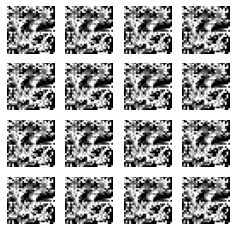

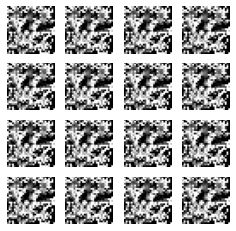

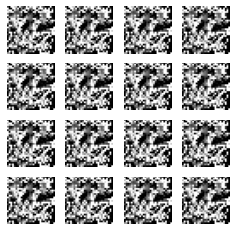

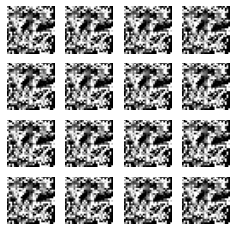

In [ ]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the DCGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

In [ ]:
import numpy as np
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

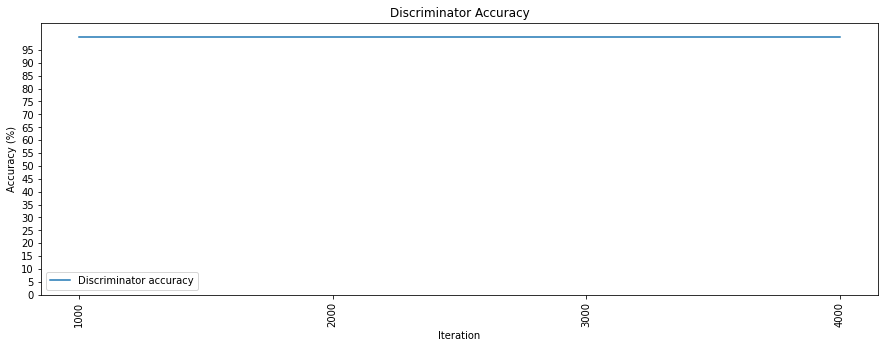

In [ ]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

# Conditional GAN 實作

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
               Embedding, Flatten, Input, Multiply, Reshape)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

# Generator

In [ ]:
def build_generator(z_dim):

  model = Sequential()

  # Reshape input into 7x7x256 tensor via a fully connected layer
  model.add(Dense(256 * 7 * 7, input_dim=z_dim))
  model.add(Reshape((7, 7, 256)))

  # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

  # Batch normalization
  model.add(BatchNormalization())

  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

  # Batch normalization
  model.add(BatchNormalization())

  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

  # Output layer with tanh activation
  model.add(Activation('tanh'))

  return model

In [ ]:
def build_cgan_generator(z_dim):

  # Random noise vector z
  z = Input(shape=(z_dim, ))

  # Conditioning label: integer 0-9 specifying the number G should generate
  label = Input(shape=(1, ), dtype='int32')

  # Label embedding:
  # ----------------
  # Turns labels into dense vectors of size z_dim
  # Produces 3D tensor with shape (batch_size, 1, z_dim)
  label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)

  # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, z_dim)
  label_embedding = Flatten()(label_embedding)

  # Element-wise product of the vectors z and the label embeddings
  joined_representation = Multiply()([z, label_embedding])

  generator = build_generator(z_dim)

  # Generate image for the given label
  conditioned_img = generator(joined_representation)

  return Model([z, label], conditioned_img)

# Discriminator

In [ ]:
def build_discriminator(img_shape):

  model = Sequential()

  # Convolutional layer, from 28x28x2 into 14x14x64 tensor
  model.add(Conv2D(64,
          kernel_size=3,
          strides=2,
          input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1),
          padding='same'))

  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Convolutional layer, from 14x14x64 into 7x7x64 tensor
  model.add(Conv2D(64,
          kernel_size=3,
          strides=2,
          input_shape=img_shape,
          padding='same'))

  # Batch normalization
  model.add(BatchNormalization())

  # Leaky ReLU activation
  model.add(LeakyReLU(alpha=0.01))

  # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
  model.add(Conv2D(128,
          kernel_size=3,
          strides=2,
          input_shape=img_shape,
          padding='same'))

  # Batch normalization
  model.add(BatchNormalization())

  # Leaky ReLU
  model.add(LeakyReLU(alpha=0.01))

  # Output layer with sigmoid activation
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
def build_cgan_discriminator(img_shape):

  # Input image
  img = Input(shape=img_shape)

  # Label for the input image
  label = Input(shape=(1, ), dtype='int32')

  # Label embedding:
  # ----------------
  # Turns labels into dense vectors of size z_dim
  # Produces 3D tensor with shape (batch_size, 1, 28*28*1)
  label_embedding = Embedding(num_classes,
                np.prod(img_shape),
                input_length=1)(label)

  # Flatten the embedding 3D tensor into 2D tensor with shape (batch_size, 28*28*1)
  label_embedding = Flatten()(label_embedding)

  # Reshape label embeddings to have same dimensions as input images
  label_embedding = Reshape(img_shape)(label_embedding)

  # Concatenate images with their label embeddings
  concatenated = Concatenate(axis=-1)([img, label_embedding])

  discriminator = build_discriminator(img_shape)

  # Classify the image-label pair
  classification = discriminator(concatenated)

  return Model([img, label], classification)

# Build the Model

In [ ]:
def build_cgan(generator, discriminator):

  # Random noise vector z
  z = Input(shape=(z_dim, ))

  # Image label
  label = Input(shape=(1, ))

  # Generated image for that label
  img = generator([z, label])

  classification = discriminator([img, label])

  # Combined Generator -> Discriminator model
  # G([z, lablel]) = x*
  # D(x*) = classification
  model = Model([z, label], classification)

  return model

In [ ]:
# Build and compile the Discriminator
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
          optimizer=Adam(),
          metrics=['accuracy'])

# Build the Generator
generator = build_cgan_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile CGAN model with fixed Discriminator to train the Generator
cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

# Training

In [ ]:
accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):

  # Load the MNIST dataset
  (X_train, y_train), (_, _) = mnist.load_data()

  # Rescale [0, 255] grayscale pixel values to [-1, 1]
  X_train = X_train / 127.5 - 1.
  X_train = np.expand_dims(X_train, axis=3)

  # Labels for real images: all ones
  real = np.ones((batch_size, 1))

  # Labels for fake images: all zeros
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):

    # -------------------------
    #  Train the Discriminator
    # -------------------------

    # Get a random batch of real images and their labels
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]

    # Generate a batch of fake images
    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict([z, labels])

    # Train the Discriminator
    d_loss_real = discriminator.train_on_batch([imgs, labels], real)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train the Generator
    # ---------------------

    # Generate a batch of noise vectors
    z = np.random.normal(0, 1, (batch_size, z_dim))

    # Get a batch of random labels
    labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

    # Train the Generator
    g_loss = cgan.train_on_batch([z, labels], real)

    if (iteration + 1) % sample_interval == 0:

      # Output training progress
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
          (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))

      # Save losses and accuracies so they can be plotted after training
      losses.append((d_loss[0], g_loss))
      accuracies.append(100 * d_loss[1])

      # Output sample of generated images
      sample_images()

In [ ]:
def sample_images(image_grid_rows=2, image_grid_columns=5):

  # Sample random noise
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

  # Get image labels 0-9
  labels = np.arange(0, 10).reshape(-1, 1)

  # Generate images from random noise
  gen_imgs = generator.predict([z, labels])

  # Rescale image pixel values to [0, 1]
  gen_imgs = 0.5 * gen_imgs + 0.5

  # Set image grid
  fig, axs = plt.subplots(image_grid_rows,
                image_grid_columns,
                figsize=(10, 4),
                sharey=True,
                sharex=True)

  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      # Output a grid of images
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      axs[i, j].set_title("Digit: %d" % labels[cnt])
      cnt += 1

# Train the Model and Inspect Training Progress

11493376/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.000071, acc.: 100.00%] [G loss: 0.319988]
2000 [D loss: 0.000138, acc.: 100.00%] [G loss: 0.088860]
3000 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.011201]
4000 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.003335]
5000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.001613]
6000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000966]
7000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000518]
8000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000333]
9000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000162]
10000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000072]
11000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000061]
12000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.000042]


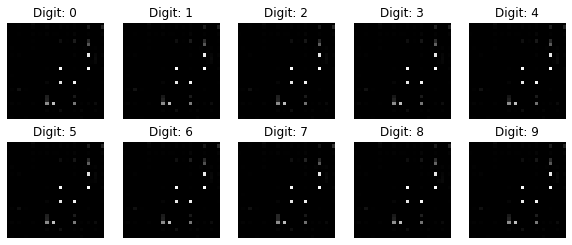

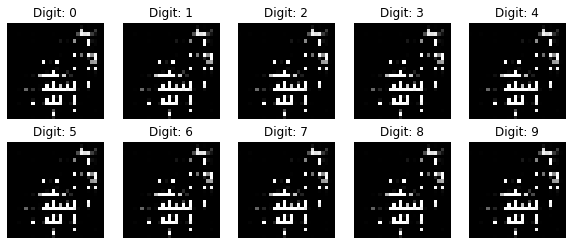

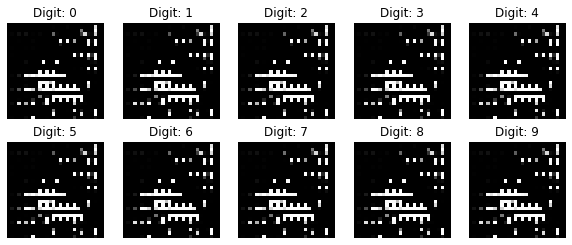

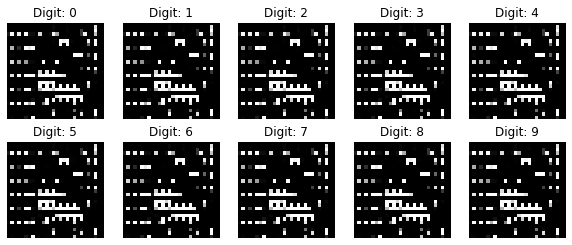

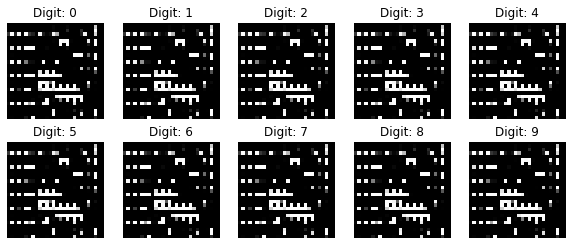

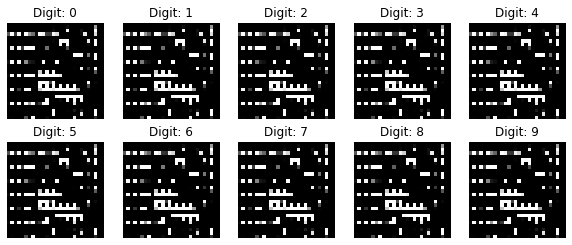

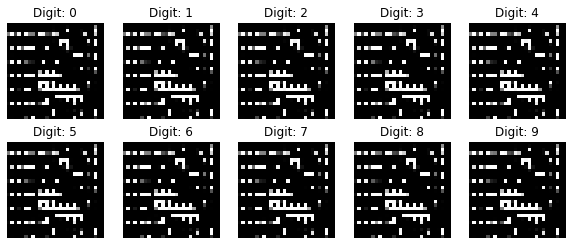

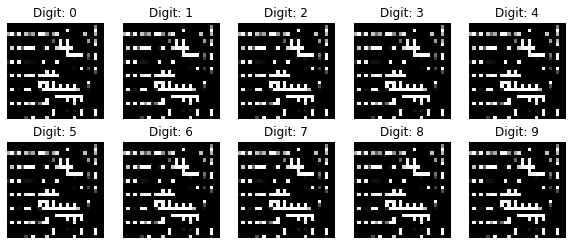

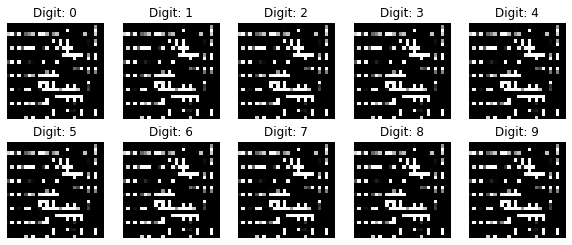

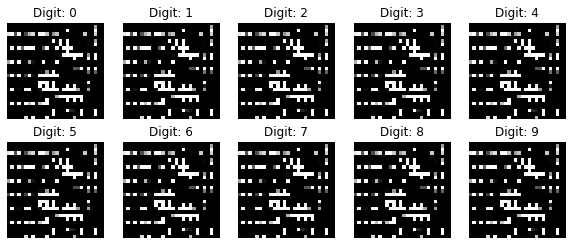

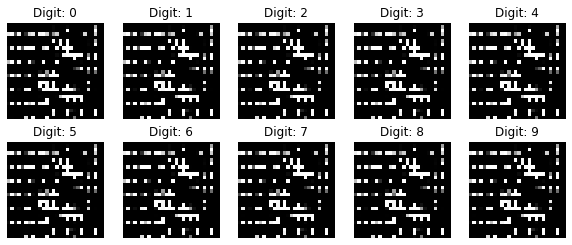

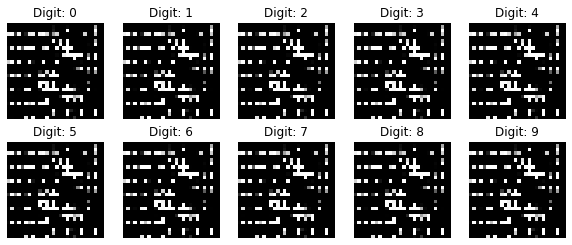

In [ ]:
# Set hyperparameters
iterations = 12000
batch_size = 32
sample_interval = 1000

# Train the CGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

# Output from a Trained CGAN Model

In [ ]:
# Set grid dimensions
image_grid_rows = 10
image_grid_columns = 5

# Sample random noise
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# Get image labels to generate: 5 samples for each label
labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# Generate images from random noise
gen_imgs = generator.predict([z, labels_to_generate])

# Rescale image pixel values to [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

# Set image grid
fig, axs = plt.subplots(image_grid_rows,
            image_grid_columns,
            figsize=(10, 20),
            sharey=True,
            sharex=True)

cnt = 0
for i in range(image_grid_rows):
  for j in range(image_grid_columns):
    # Output a grid of images
    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
    axs[i, j].axis('off')
    axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt]) ## NEW
    cnt += 1